# Nvdiffmodeling 算法测试

[GitHub](https://github.com/NVlabs/nvdiffmodeling) | [Paper](https://research.nvidia.com/publication/2021-04_appearance-driven-automatic-3d-model-simplification) | [Video](https://d1qx31qr3h6wln.cloudfront.net/publications/autolod_video.mp4)

问题：    
1. 为什么Radius参数会用于camera eye位置初始化？
2. 为什么加载json配置文件覆盖camera eye设置后不需要变更对应的radius？
3. FLAGS.layers 代表什么？

In [1]:
import os
import sys
import time
import argparse
import json

import numpy as np
import torch
import torch.nn.functional as F
import nvdiffrast.torch as dr

import src.renderutils as ru
from src import obj
from src import util
from src import mesh
from src import texture
from src import render
from src import regularizer
from src.mesh import Mesh
from src import helper

import matplotlib.pyplot as plt

Using C:\Users\zhong\AppData\Local\torch_extensions\torch_extensions\Cache\py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\zhong\AppData\Local\torch_extensions\torch_extensions\Cache\py310_cu121\renderutils_plugin\build.ninja...
Building extension module renderutils_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module renderutils_plugin...


## 全局参数加载

In [5]:
CONFIG_FILE = "configs/spot.json"
FLAGS = helper.init_flags(args=['--config', CONFIG_FILE])

----配置信息----
迭代次数(iter):1000
批大小(batch):8
单像素采样数(spp):1
层数(layers):1
训练分辨率(train_res):512
随机训练分辨率(random_train_res):False
显示分辨率(display_res):512
材质分辨率(texture_res):[1024, 1024]
显示间隔(display_interval):0
保存间隔(save_interval):1000
学习率(learning_rate):0.03
光功率(light_power):5.0
最小粗糙度(min_roughness):0.25
细分(subdivision):0
自定义mip(custom_mip):False
随机纹理(random_textures):True
拉普拉斯因子(laplacian_factor):None
相对拉普拉斯(relative_laplacian):False
背景(background):checker
损失函数(loss):logl1
输出文件目录(out_dir):out/spot
配置文件(config):configs/spot.json
参考网格(ref_mesh):data/spot/spot.obj
基础网格(base_mesh):data/sphere.obj
相机位置(camera_eye):[2.5, 0.0, -2.5]
相机朝向(camera_up):[0.0, 1.0, 0.0]
弧度(radius):3.5
投影矩阵(proj_mtx):[[ 2.5       0.        0.        0.      ]
 [ 0.       -2.5       0.        0.      ]
 [ 0.        0.       -1.002002 -2.002002]
 [ 0.        0.       -1.        0.      ]]
跳过训练(skip_train):[]
位移(displacement):0.15
材质重写(mtl_override):None


## 数据加载

### 创建输出文件目录

In [3]:
os.makedirs(FLAGS.out_dir, exist_ok=True)
os.makedirs(os.path.join(FLAGS.out_dir, "mesh"), exist_ok=True)

### 网格加载（Mesh Loading）

In [4]:
# 加载参考网格
ref_mesh = helper.load_mesh(FLAGS.ref_mesh, FLAGS.mtl_override)
print("参考网格包含 %d 三角面和 %d 顶点，平均边长为：%.4f" % (ref_mesh.t_pos_idx.shape[0], ref_mesh.v_pos.shape[0], regularizer.avg_edge_length(ref_mesh)))

<class 'numpy.ndarray'>


TypeError: expected size to be one of int or Tuple[int] or Tuple[int, int] or Tuple[int, int, int], but got size with types [<class 'numpy.int32'>, <class 'numpy.int32'>]

In [7]:
# 加载基础网格
base_mesh = load_mesh(FLAGS.base_mesh)
print("基础网格包含 %d 三角面和 %d 顶点，平均边长为：%.4f" % (base_mesh.t_pos_idx.shape[0], base_mesh.v_pos.shape[0], regularizer.avg_edge_length(base_mesh)))

def check_resolution(ref_mesh, texture_res):
    # 检测训练纹理的分辨率是否合规
    # Check if the training texture resolution is acceptable
    ref_texture_res = np.maximum(ref_mesh.material['kd'].getRes(), ref_mesh.material['ks'].getRes())
    if 'normal' in ref_mesh.material:
        ref_texture_res = np.maximum(ref_texture_res, ref_mesh.material['normal'].getRes())
    if texture_res[0] < ref_texture_res[0] or texture_res[1] < ref_texture_res[1]:
        print("---> 警告: 所选纹理分辨率小于参考网格纹理分辨率 [%d, %d] < [%d, %d]" % (texture_res[0], texture_res[1], ref_texture_res[0], ref_texture_res[1]))

check_resolution(ref_mesh, FLAGS.texture_res)

# 计算预期优化效果
t_reduction_rate = (1 - base_mesh.t_pos_idx.shape[0] / ref_mesh.t_pos_idx.shape[0]) * 100
v_reduction_rate = (1 - base_mesh.v_pos.shape[0] / ref_mesh.v_pos.shape[0]) * 100
print("预期减面率为: %.2f%%" % t_reduction_rate)
print("预期减点率为: %.2f%%" % v_reduction_rate)

参考网格包含 5856 三角面和 2930 顶点，平均边长为：0.0684
基础网格包含 3072 三角面和 1538 顶点，平均边长为：0.1346
预期减面率为: 47.54%
预期减点率为: 47.51%


### 网格归一化（Mesh Normalization）

In [8]:
normalized_base_mesh = mesh.unit_size(base_mesh)
normalized_ref_mesh = mesh.unit_size(ref_mesh)

## 初始化训练网格的权重和变量

In [9]:
trainable_list = []
# 归一化基础网格顶点
v_pos_opt = normalized_base_mesh.v_pos.clone().detach().requires_grad_(True)
v_pos_opt

tensor([[-0.5956, -0.5956,  0.5956],
        [-0.0921, -0.7230,  0.7230],
        [-0.1827, -0.7143,  0.7143],
        ...,
        [-0.9572,  0.3001, -0.0988],
        [-0.9786,  0.2018, -0.1003],
        [-0.9914,  0.1014, -0.1014]], device='cuda:0', requires_grad=True)

#### 构建可训练的法线贴图，初始化为(0,0,1)，并确保法向量总处于正半球。
Trainable normal map, initialize to (0,0,1) & make sure normals are always in positive hemisphere

In [10]:
if FLAGS.random_textures:
    normal_map_opt = texture.create_trainable(np.array([0, 0, 1]), FLAGS.texture_res, not FLAGS.custom_mip)
else:
    if 'normal' not in ref_mesh.material:
        normal_map_opt = texture.create_trainable(np.array([0, 0, 1]), FLAGS.texture_res, not FLAGS.custom_mip)
    else:
        normal_map_opt = texture.create_trainable(ref_mesh.material['normal'], FLAGS.texture_res, not FLAGS.custom_mip)

#### 创建可训练 Kd,Ks 反照率和高光纹理
Setup Kd, Ks albedo and specular textures

In [11]:
if FLAGS.random_textures:
    if FLAGS.layers > 1:
        kd_map_opt = texture.create_trainable(np.random.uniform(size=FLAGS.texture_res + [4], low=0.0, high=1.0), FLAGS.texture_res, not FLAGS.custom_mip)
    else:
        kd_map_opt = texture.create_trainable(np.random.uniform(size=FLAGS.texture_res + [3], low=0.0, high=1.0), FLAGS.texture_res, not FLAGS.custom_mip)

    ksR = np.random.uniform(size=FLAGS.texture_res + [1], low=0.0, high=0.01)
    ksG = np.random.uniform(size=FLAGS.texture_res + [1], low=FLAGS.min_roughness, high=1.0)
    ksB = np.random.uniform(size=FLAGS.texture_res + [1], low=0.0, high=1.0)
    ks_map_opt = texture.create_trainable(np.concatenate((ksR, ksG, ksB), axis=2), FLAGS.texture_res, not FLAGS.custom_mip)
else:
    kd_map_opt = texture.create_trainable(ref_mesh.material['kd'], FLAGS.texture_res, not FLAGS.custom_mip)
    ks_map_opt = texture.create_trainable(ref_mesh.material['ks'], FLAGS.texture_res, not FLAGS.custom_mip)

反照率贴图： torch.Size([1, 1024, 1024, 3])


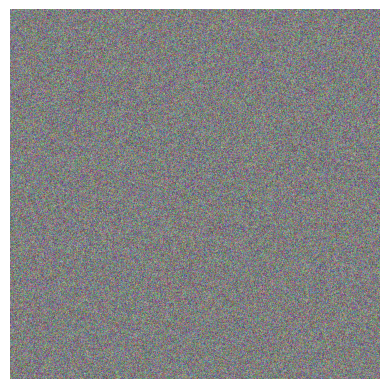

In [13]:
print("反照率贴图：", kd_map_opt.data.shape)
showImageTensor(kd_map_opt.data)

高光贴图：   torch.Size([1, 1024, 1024, 3])


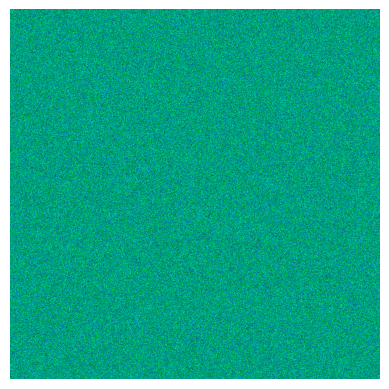

In [14]:
print("高光贴图：  ", ks_map_opt.data.shape)
showImageTensor(ks_map_opt.data)

#### 创建位移贴图
Trainable displacement map

In [15]:
displacement_map_var = None
if FLAGS.subdivision > 0:
    displacement_map_var = torch.tensor(np.zeros(FLAGS.texture_res + [1], dtype=np.float32), dtype=torch.float32, device='cuda', requires_grad=True)

#### 根据配置信息组合训练参数
Add trainable arguments according to config

In [16]:
if not 'position' in FLAGS.skip_train:
    trainable_list += [v_pos_opt]        
if not 'normal' in FLAGS.skip_train:
    trainable_list += normal_map_opt.getMips()
if not 'kd' in FLAGS.skip_train:
    trainable_list += kd_map_opt.getMips()
if not 'ks' in FLAGS.skip_train:
    trainable_list += ks_map_opt.getMips()
if not 'displacement' in FLAGS.skip_train and displacement_map_var is not None:
    trainable_list += [displacement_map_var]

## 配置用于网格优化的材质
Setup material for optimized mesh

In [17]:
opt_material = {
    'bsdf'   : ref_mesh.material['bsdf'],
    'kd'     : kd_map_opt,
    'ks'     : ks_map_opt,
    'normal' : normal_map_opt
}

## 配置参考网格
Setup reference mesh. Compute tangentspace and animate with skinning

In [18]:
render_ref_mesh = mesh.compute_tangents(ref_mesh)

# Compute AABB of reference mesh. Used for centering during rendering TODO: Use pre frame AABB?
ref_mesh_aabb = mesh.aabb(render_ref_mesh.eval())

## 配置基础网格及预计算
Setup base mesh operation graph, precomputes topology etc.

In [19]:
# Create optimized mesh with trainable positions 
opt_base_mesh = Mesh(v_pos_opt, normalized_base_mesh.t_pos_idx, material=opt_material, base=normalized_base_mesh)

# Scale from [-1, 1] local coordinate space to match extents of the reference mesh
opt_base_mesh = mesh.align_with_reference(opt_base_mesh, ref_mesh)

# Compute smooth vertex normals
opt_base_mesh = mesh.auto_normals(opt_base_mesh)

# Set up tangent space
opt_base_mesh = mesh.compute_tangents(opt_base_mesh)

# Subdivide if we're doing displacement mapping
if FLAGS.subdivision > 0:
    # Subdivide & displace optimized mesh
    subdiv_opt_mesh = mesh.subdivide(opt_base_mesh, steps=FLAGS.subdivision)
    opt_detail_mesh = mesh.displace(subdiv_opt_mesh, displacement_map_var, FLAGS.displacement, keep_connectivity=True)
else:
    opt_detail_mesh = opt_base_mesh

# Laplace regularizer
if FLAGS.relative_laplacian:
    with torch.no_grad():
        orig_opt_base_mesh = opt_base_mesh.eval().clone()
    lap_loss_fn = regularizer.laplace_regularizer_const(opt_detail_mesh, orig_opt_base_mesh)
else:
    lap_loss_fn = regularizer.laplace_regularizer_const(opt_detail_mesh)

## 配置优化器
Setup torch optimizer

In [20]:
optimizer  = torch.optim.Adam(trainable_list, lr=FLAGS.learning_rate)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: max(0.0, 10**(-x*0.0002))) 

## 创建图像损失
Image loss

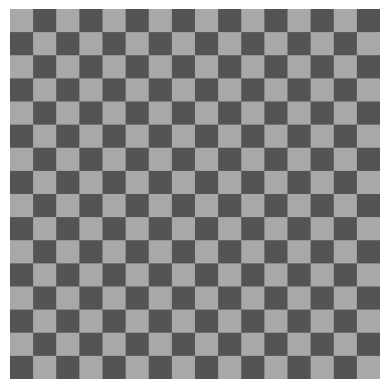

In [21]:
image_loss_fn = createLoss(FLAGS)

# Background color
if FLAGS.background == 'checker':
    background = torch.tensor(util.checkerboard(FLAGS.display_res, 8), dtype=torch.float32, device='cuda')
elif FLAGS.background == 'white':
    background = torch.ones((1, FLAGS.display_res, FLAGS.display_res, 3), dtype=torch.float32, device='cuda')
else:
    background = None

showImageTensor(background)

## 训练

In [22]:
def getRenderParams(flags):
    eye = np.array(flags.camera_eye)
    up  = np.array(flags.camera_up)
    at  = np.array([0,0,0])
    a_mv =  util.lookAt(eye, at, up)                                      # 模型视图（Model View）
    a_mvp = np.matmul(flags.proj_mtx, a_mv).astype(np.float32)[None, ...] # 模型视图投影（Model View Projection）
    a_lightpos = np.linalg.inv(a_mv)[None, :3, 3]
    a_campos = np.linalg.inv(a_mv)[None, :3, 3]
    return {'mvp' : a_mvp, 'lightpos' : a_lightpos, 'campos' : a_campos, 'resolution' : [FLAGS.display_res, FLAGS.display_res], 'time' : 0}

In [26]:
def renderScene(glctx, opt_base_mesh, opt_detail_mesh, render_ref_mesh, ref_mesh_aabb, background, displacement_map_var, FLAGS, mesh_scale, params):
    # Center meshes
    _opt_detail = mesh.center_by_reference(opt_detail_mesh.eval(params), ref_mesh_aabb, mesh_scale)
    _opt_ref    = mesh.center_by_reference(render_ref_mesh.eval(params), ref_mesh_aabb, mesh_scale)

    # Render
    if FLAGS.subdivision > 0:
        _opt_base   = mesh.center_by_reference(opt_base_mesh.eval(params), ref_mesh_aabb, mesh_scale)
        img_base = render.render_mesh(glctx, _opt_base, params['mvp'], params['campos'], params['lightpos'], FLAGS.light_power, FLAGS.display_res, 
            num_layers=FLAGS.layers, background=background, min_roughness=FLAGS.min_roughness)
        img_base = util.scale_img_nhwc(img_base, [FLAGS.display_res, FLAGS.display_res])

    img_opt = render.render_mesh(glctx, _opt_detail, params['mvp'], params['campos'],  params['lightpos'], FLAGS.light_power, FLAGS.display_res, 
        num_layers=FLAGS.layers, background=background, min_roughness=FLAGS.min_roughness)
    img_ref = render.render_mesh(glctx, _opt_ref, params['mvp'], params['campos'],  params['lightpos'], FLAGS.light_power, FLAGS.display_res, 
        num_layers=1, spp=FLAGS.spp, background=background, min_roughness=FLAGS.min_roughness)

    # Rescale
    img_opt  = util.scale_img_nhwc(img_opt,  [FLAGS.display_res, FLAGS.display_res])
    img_ref  = util.scale_img_nhwc(img_ref,  [FLAGS.display_res, FLAGS.display_res])

    if FLAGS.subdivision > 0:
        img_disp = torch.clamp(torch.abs(displacement_map_var[None, ...]), min=0.0, max=1.0).repeat(1,1,1,3)
        img_disp = util.scale_img_nhwc(img_disp, [FLAGS.display_res, FLAGS.display_res])
        result_image = torch.cat([img_base, img_opt, img_ref], axis=2)
    else:
        result_image = torch.cat([img_opt, img_ref], axis=2)
    return result_image

In [27]:
def displayAndSaveImage(glctx, opt_base_mesh, opt_detail_mesh, render_ref_mesh, ref_mesh_aabb, background, displacement_map_var, mesh_scale, img_cnt, it, FLAGS):
    display_image = FLAGS.display_interval and (it % FLAGS.display_interval == 0)
    save_image    = FLAGS.save_interval    and (it % FLAGS.save_interval == 0)

    params = getRenderParams(FLAGS)
    with torch.no_grad():
        result_image = renderScene(glctx, opt_base_mesh, opt_detail_mesh, render_ref_mesh, ref_mesh_aabb, background, displacement_map_var, FLAGS, mesh_scale, params)

    result_image[0] = util.tonemap_srgb(result_image[0])
    np_result_image = result_image[0].detach().cpu().numpy()
    
    if display_image:
        util.display_image(np_result_image, size=FLAGS.display_res, title='%d / %d' % (it, FLAGS.iter))
    if save_image:
        util.save_image(FLAGS.out_dir + '/' + ('img_%06d.png' % img_cnt), np_result_image)
        img_cnt = img_cnt+1
    return img_cnt

In [ ]:
# ==============================================================================================
#  训练循环
#  Training Loop
# ==============================================================================================
img_cnt = 0        # 图片计数
ang = 0.0          #
img_loss_vec = []  # 图片损失向量集
lap_loss_vec = []  #
iter_dur_vec = []  #
mesh_scale=2.0

log_interval = 10

glctx = dr.RasterizeGLContext() # 可微渲染管线
for it in range(FLAGS.iter+1):
    
    # ==============================================================================================
    #  展示/保存输出。在最初执行用以获得初始网格数据。
    #  Display / save outputs. Do it before training so we get initial meshes
    # ==============================================================================================
    img_cnt = displayAndSaveImage(glctx, opt_base_mesh, opt_detail_mesh, render_ref_mesh, ref_mesh_aabb, 
                                  background, displacement_map_var, mesh_scale, img_cnt, it, FLAGS)    
    # ==============================================================================================
    #  训练初始化
    #  Initailize Training
    # ==============================================================================================
    iter_start_time = time.time()                                    # 记录迭代开始时间
    img_loss = torch.zeros([1], dtype=torch.float32, device='cuda')  # 初始化图像空间损失
    lap_loss = torch.zeros([1], dtype=torch.float32, device='cuda')  # 初始化laplace损失

    iter_res = FLAGS.train_res # 初始化分辨率
    iter_spp = FLAGS.spp       # 初始化单像素采样率
    if FLAGS.random_train_res:
        # 分辨率随机化
        # Random resolution, 16x16 -> train_res. Scale up sample count so we always land close to train_res*samples_per_pixel samples
        iter_res = np.random.randint(16, FLAGS.train_res+1)
        iter_spp = FLAGS.spp * (FLAGS.train_res // iter_res)
 
    mvp      = np.zeros((FLAGS.batch, 4,4), dtype=np.float32) # 模型视图投影矩阵（Model View Projection）
    campos   = np.zeros((FLAGS.batch, 3),   dtype=np.float32) # 相机位置（Camera Position）
    lightpos = np.zeros((FLAGS.batch, 3),   dtype=np.float32) # 光源位置（Light Position）

    # ==============================================================================================
    #  构建用于minibatching的变换栈
    #  Build transform stack for minibatching
    # ==============================================================================================
    for b in range(FLAGS.batch):
        # 随机旋转/平移矩阵用于优化
        # Random rotation/translation matrix for optimization.
        r_rot      = util.random_rotation_translation(0.25)                 # 随机渲染矩阵
        r_mv       = np.matmul(util.translate(0, 0, -FLAGS.radius), r_rot)  # 随机模型视图
        mvp[b]     = np.matmul(FLAGS.proj_mtx, r_mv).astype(np.float32)     # 随机模型视图投影
        campos[b]  = np.linalg.inv(r_mv)[:3, 3]                             # 随机相机位置
        lightpos[b] = util.cosine_sample(campos[b])*FLAGS.radius            # 随机光源位置
    params = {'mvp' : mvp, 'lightpos' : lightpos, 'campos' : campos, 'resolution' : [iter_res, iter_res], 'time' : 0}
    # 随机背景颜色
    # Random bg color
    randomBgColor = torch.rand(FLAGS.batch, iter_res, iter_res, 3, dtype=torch.float32, device='cuda')
    # ==============================================================================================
    #  居中对齐所有网格
    #  Evaluate all mesh ops (may change when positions are modified etc) and center/align meshes
    # ==============================================================================================
    _opt_ref  = mesh.center_by_reference(render_ref_mesh.eval(params), ref_mesh_aabb, mesh_scale)
    _opt_detail = mesh.center_by_reference(opt_detail_mesh.eval(params), ref_mesh_aabb, mesh_scale)
    # ==============================================================================================
    #  渲染参考网格
    #  Render reference mesh
    # ==============================================================================================
    with torch.no_grad():
        color_ref = render.render_mesh(glctx, _opt_ref, mvp, campos, lightpos, FLAGS.light_power, iter_res, spp=iter_spp, num_layers=1, 
                                       background=randomBgColor, min_roughness=FLAGS.min_roughness)
    # ==============================================================================================
    #  渲染训练网格
    #  Render the trainable mesh
    # ==============================================================================================
    color_opt = render.render_mesh(glctx, _opt_detail, mvp, campos, lightpos, FLAGS.light_power, iter_res, spp=iter_spp, num_layers=FLAGS.layers, 
                                   msaa=True , background=randomBgColor, min_roughness=FLAGS.min_roughness)
    # ==============================================================================================
    #  损失计算
    #  Compute loss
    # ==============================================================================================
    # 计算图像空间损失
    img_loss = image_loss_fn(color_opt, color_ref)
    # 计算laplace损失
    lap_loss = lap_loss_fn.eval(params)

    # Debug, store every training iteration
    # result_image = torch.cat([color_opt, color_ref], axis=2)
    # np_result_image = result_image[0].detach().cpu().numpy()
    # util.save_image(out_dir + '/' + ('train_%06d.png' % it), np_result_image)

    # 记录损失
    img_loss_vec.append(img_loss.item())
    lap_loss_vec.append(lap_loss.item())

    # Schedule for laplacian loss weight
    if it == 0:
        if FLAGS.laplacian_factor is not None:
            lap_fac = FLAGS.laplacian_factor
        else:
            ratio = 0.1 / lap_loss.item() # Hack that assumes RMSE ~= 0.1
            lap_fac = ratio * 0.25
        min_lap_fac = lap_fac * 0.02
    else:
        lap_fac = (lap_fac - min_lap_fac) * 10**(-it*0.000001) + min_lap_fac

    # Compute total aggregate loss
    total_loss = img_loss + lap_loss * lap_fac

    # ==============================================================================================
    #  反向传播（Backpropagate）
    # ==============================================================================================
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    # ==============================================================================================
    #  将训练参数裁剪至合理区间（Clamp trainables to reasonable range）
    # ==============================================================================================
    normal_map_opt.clamp_(min=-1, max=1)
    kd_map_opt.clamp_(min=0, max=1)
    ks_map_opt.clamp_rgb_(minR=0, maxR=1, minG=FLAGS.min_roughness, maxG=1.0, minB=0.0, maxB=1.0)
    iter_dur_vec.append(time.time() - iter_start_time)
    # ==============================================================================================
    #  保存日志（Log & save outputs）
    # ==============================================================================================
    if log_interval and (it % log_interval == 0):
        with torch.no_grad():
            showBatchImageTensor(color_ref, FLAGS.batch)
            showBatchImageTensor(color_opt, FLAGS.batch)
        
        img_loss_avg = np.mean(np.asarray(img_loss_vec[-log_interval:]))
        lap_loss_avg = np.mean(np.asarray(lap_loss_vec[-log_interval:]))
        iter_dur_avg = np.mean(np.asarray(iter_dur_vec[-log_interval:]))
        remaining_time = (FLAGS.iter-it)*iter_dur_avg
        print("iter=%5d, img_loss=%.6f, lap_loss=%.6f, lr=%.5f, time=%.1f ms, rem=%s" % 
            (it, img_loss_avg, lap_loss_avg*lap_fac, optimizer.param_groups[0]['lr'], iter_dur_avg*1000, util.time_to_text(remaining_time)))

# Save final mesh to file
obj.write_obj(os.path.join(FLAGS.out_dir, "mesh/"), opt_base_mesh.eval())